In [55]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, TensorDataset
import numpy as np
from itertools import product
import os
from sklearn.metrics import accuracy_score
import pandas as pd
import json
import inspect



# Define transformation: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # CIFAR-10 normalization values
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Preview some images with their labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [56]:
# Check for GPU availability in PyTorch
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available")
    device = torch.device("cpu")


GPU is available


In [57]:
# Define evaluation function for CNN model in PyTorch
def evaluate_cnn_model(model, dataloader, model_name, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    
    # No gradient calculation needed in evaluation mode
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Store predictions and true labels
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)
    
    # Print results
    print(f'Model: {model_name}')
    print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
    
    # Return results as a DataFrame for consistency
    return pd.DataFrame({
        'Model Name': [model_name],
        'Overall Accuracy': [overall_accuracy]
    })


In [58]:
def train_and_evaluate_cnn_model(build_model_fn, model_name, train_loader, valid_loader,
                                 optimizer_class, learning_rate, dropout_rate=0.1, 
                                 num_epochs=30, patience=3, device='cpu'):
    # Define model and history paths
    model_dir = "saved_models_tor"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"{model_name}.pth")
    history_path = os.path.join(model_dir, f"{model_name}_history.json")

    # Check if model-building function accepts `dropout_rate`
    model_args = inspect.signature(build_model_fn).parameters
    model_kwargs = {'num_classes': 10}  # Set default arguments
    
    if 'dropout_rate' in model_args:
        model_kwargs['dropout_rate'] = dropout_rate
    
    # Initialize the model with conditional arguments
    model = build_model_fn(**model_kwargs).to(device)
    
    # Check if the model and history files exist and are not empty
    if os.path.exists(model_path) and os.path.exists(history_path) and os.path.getsize(history_path) > 0:
        model.load_state_dict(torch.load(model_path))  # Load the saved model
        print(f"Loaded model from {model_path}")
        
        # Load history from JSON file
        with open(history_path, 'r') as f:
            history = json.load(f)
        print(f"Loaded training history from {history_path}")
        
        # Perform evaluation directly on the validation set
        y_pred, y_true = [], []
        with torch.no_grad():
            model.eval()
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        
        overall_accuracy = accuracy_score(y_true, y_pred)
        print(f'Model: {model_name}')
        print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
        
        # Return result and history without retraining
        result_df = pd.DataFrame({
            'Model Name': [model_name],
            'Overall Accuracy': [overall_accuracy]
        })
        return result_df, history, model_name
    
    # If model or history doesn't exist, proceed with training
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= total
        val_acc = correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)  # Save the best model
            print(f"Saved model to {model_path}")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Save history to a JSON file
    with open(history_path, 'w') as f:
        json.dump(history, f)
    print(f"Training history saved to {history_path}")

    # Load the best model for evaluation
    model.load_state_dict(torch.load(model_path))

    # Evaluate the final model on the validation set
    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f'Model: {model_name}')
    print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
    
    # Return results as a DataFrame for consistency
    result_df = pd.DataFrame({
        'Model Name': [model_name],
        'Overall Accuracy': [overall_accuracy]
    })

    return result_df, history, model_name


In [59]:
def perf_plot(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(16, 9))
    
    # Plot loss values
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    
    # Plot accuracy values
    plt.plot(epochs, history['train_acc'], label='Training Accuracy', color='green')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', color='red')
    
    plt.title(f"Model: {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


In [60]:
def perf_plot_grid(results, x, y, l, w):
    # Set up 4x2 grid layout
    fig, axes = plt.subplots(x, y, figsize=(l, w))
    fig.tight_layout(pad=4.0)

    for idx, (result_df, history, model_name) in enumerate(results):
        if idx >= 8:  # Limit to 8 plots for the 4x2 grid layout
            break
        
        ax = axes[idx // 2, idx % 2]
        
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Plot loss values
        ax.plot(epochs, history['train_loss'], label='Training Loss', color='blue')
        ax.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
        
        # Plot accuracy values
        ax.plot(epochs, history['train_acc'], label='Training Accuracy', color='green')
        ax.plot(epochs, history['val_acc'], label='Validation Accuracy', color='red')
        
        # Set titles and labels
        ax.set_title(f"Model: {model_name}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss / Accuracy")
        ax.legend(loc='best')
        ax.grid(True)  # Optional: adds gridlines for clarity
    
    plt.show()


In [61]:
class AlexNet(nn.Module):
    def __init__(self, dropout_rate=0.0, input_shape=(32, 32, 3), num_classes=10):
        super(AlexNet, self).__init__()
        
        # Define the convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[2], out_channels=96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Define the fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  # Adjust based on input size (for 32x32 input, final feature map is 4x4)
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [62]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the sizes for training and validation splits
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Split the dataset into training and validation sets
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

# Create DataLoaders for the training and validation sets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [63]:
# Function to create an instance of AlexNet
def build_alexnet(dropout_rate=0.0, input_shape=(32, 32, 3), num_classes=10):
    return AlexNet(dropout_rate=dropout_rate, input_shape=input_shape, num_classes=num_classes)

# Define parameters
model_name = "AlexNet_CIFAR10"
optimizer_class = optim.Adam  # PyTorch equivalent of tf.keras.optimizers.Adam
learning_rate = 0.01
dropout_rate = 0.0  # Adjust dropout as needed

# Train and evaluate the model using the PyTorch train_and_evaluate_cnn_model function
result_df, history, model_name = train_and_evaluate_cnn_model(
    build_alexnet,             # Model-building function
    model_name,                # Model name for saving/loading
    train_loader,              # PyTorch DataLoader for training set
    valid_loader,              # PyTorch DataLoader for validation set
    optimizer_class=optimizer_class,  # Optimizer class
    learning_rate=learning_rate,      # Learning rate
    dropout_rate=dropout_rate,        # Dropout rate
    num_epochs=30,                    # Number of epochs
    device=device                     # Device (CPU or GPU)
)

# Display the result DataFrame (accuracy) and plot performance
result_df


Loaded model from saved_models_tor\AlexNet_CIFAR10.pth
Loaded training history from saved_models_tor\AlexNet_CIFAR10_history.json
Model: AlexNet_CIFAR10
Overall Accuracy: 10.24%


,Model Name,Overall Accuracy
0,AlexNet_CIFAR10,0.1024


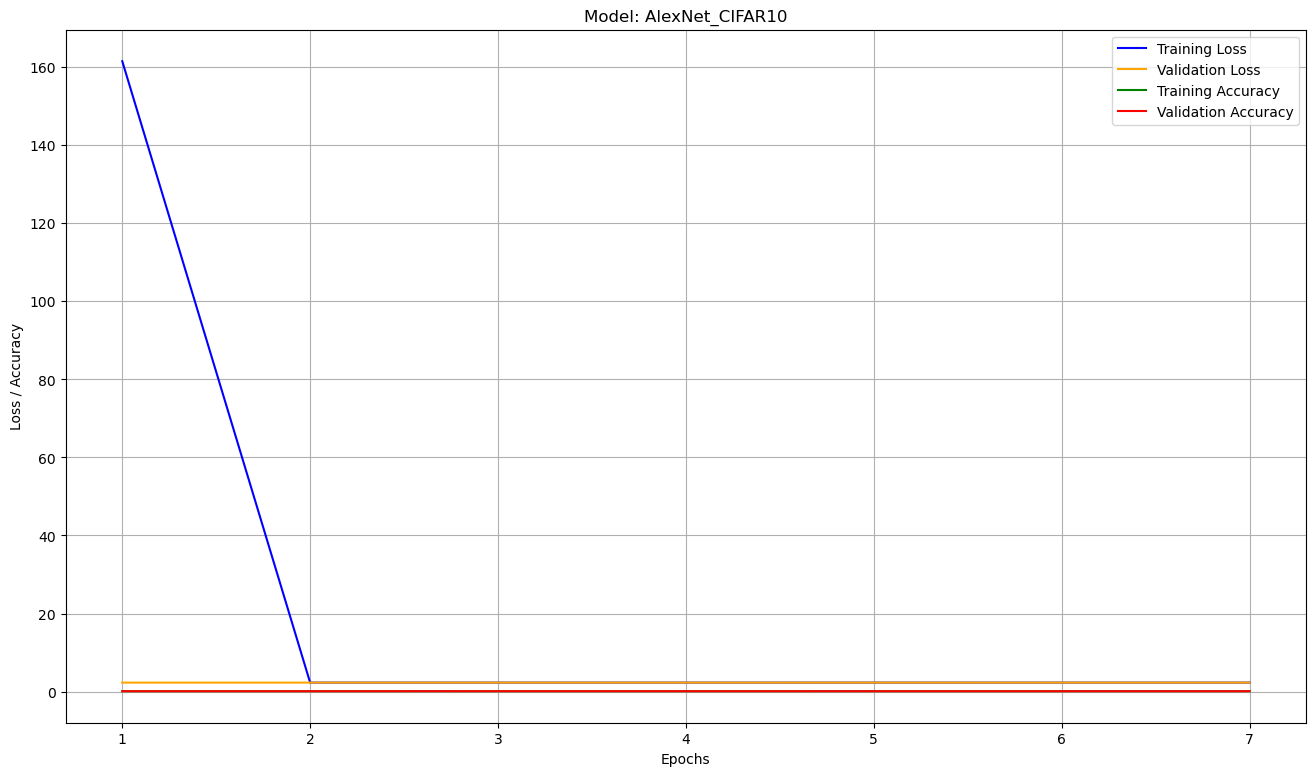

In [64]:
perf_plot(history, model_name)

In [65]:

# Define the hyperparameter grid
learning_rates = [0.001, 0.005]
optimizers = [optim.Adam, optim.SGD]  # PyTorch optimizer classes
dropout_rates = [0.1, 0.3]

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(product(learning_rates, optimizers, dropout_rates))

results = []
for lr, optimizer_class, dropout_rate in hyperparameter_combinations:
    optimizer_name = optimizer_class.__name__  # Get the name of the optimizer (e.g., 'Adam' or 'SGD')
    model_name = f"AlexNet_lr{lr}_opt{optimizer_name}_dropout{dropout_rate}"
    
    # Train and evaluate the model
    result_df, history, _ = train_and_evaluate_cnn_model(
        build_alexnet,             # Model-building function
        model_name,                # Model name for saving/loading
        train_loader,              # PyTorch DataLoader for training set
        valid_loader,              # PyTorch DataLoader for validation set
        optimizer_class=optimizer_class,  # Pass the optimizer class, not an instance
        learning_rate=lr,          # Specify the learning rate
        dropout_rate=dropout_rate, # Specify the dropout rate
        num_epochs=30,             # Number of epochs (can be modified)
        device=device              # Device (CPU or GPU)
    )
    
    # Append the results
    results.append((result_df, history, model_name))


Loaded model from saved_models_tor\AlexNet_lr0.001_optAdam_dropout0.1.pth
Loaded training history from saved_models_tor\AlexNet_lr0.001_optAdam_dropout0.1_history.json
Model: AlexNet_lr0.001_optAdam_dropout0.1
Overall Accuracy: 82.24%
Loaded model from saved_models_tor\AlexNet_lr0.001_optAdam_dropout0.3.pth
Loaded training history from saved_models_tor\AlexNet_lr0.001_optAdam_dropout0.3_history.json
Model: AlexNet_lr0.001_optAdam_dropout0.3
Overall Accuracy: 71.21%
Loaded model from saved_models_tor\AlexNet_lr0.001_optSGD_dropout0.1.pth
Loaded training history from saved_models_tor\AlexNet_lr0.001_optSGD_dropout0.1_history.json
Model: AlexNet_lr0.001_optSGD_dropout0.1
Overall Accuracy: 18.93%
Loaded model from saved_models_tor\AlexNet_lr0.001_optSGD_dropout0.3.pth
Loaded training history from saved_models_tor\AlexNet_lr0.001_optSGD_dropout0.3_history.json
Model: AlexNet_lr0.001_optSGD_dropout0.3
Overall Accuracy: 15.10%
Loaded model from saved_models_tor\AlexNet_lr0.005_optAdam_dropout

In [66]:
# Concatenate all individual result DataFrames in `results` and sort by Overall Accuracy
all_results_df = pd.concat([res[0] for res in results], ignore_index=True)
all_results_df = all_results_df.sort_values(by="Overall Accuracy", ascending=False)

# Display the sorted results
print("All Results Sorted by Overall Accuracy:")
all_results_df


All Results Sorted by Overall Accuracy:


,Model Name,Overall Accuracy
0,AlexNet_lr0.001_optAdam_dropout0.1,0.8224
1,AlexNet_lr0.001_optAdam_dropout0.3,0.7121
7,AlexNet_lr0.005_optSGD_dropout0.3,0.5993
6,AlexNet_lr0.005_optSGD_dropout0.1,0.5953
4,AlexNet_lr0.005_optAdam_dropout0.1,0.5415
5,AlexNet_lr0.005_optAdam_dropout0.3,0.4057
2,AlexNet_lr0.001_optSGD_dropout0.1,0.1893
3,AlexNet_lr0.001_optSGD_dropout0.3,0.1510


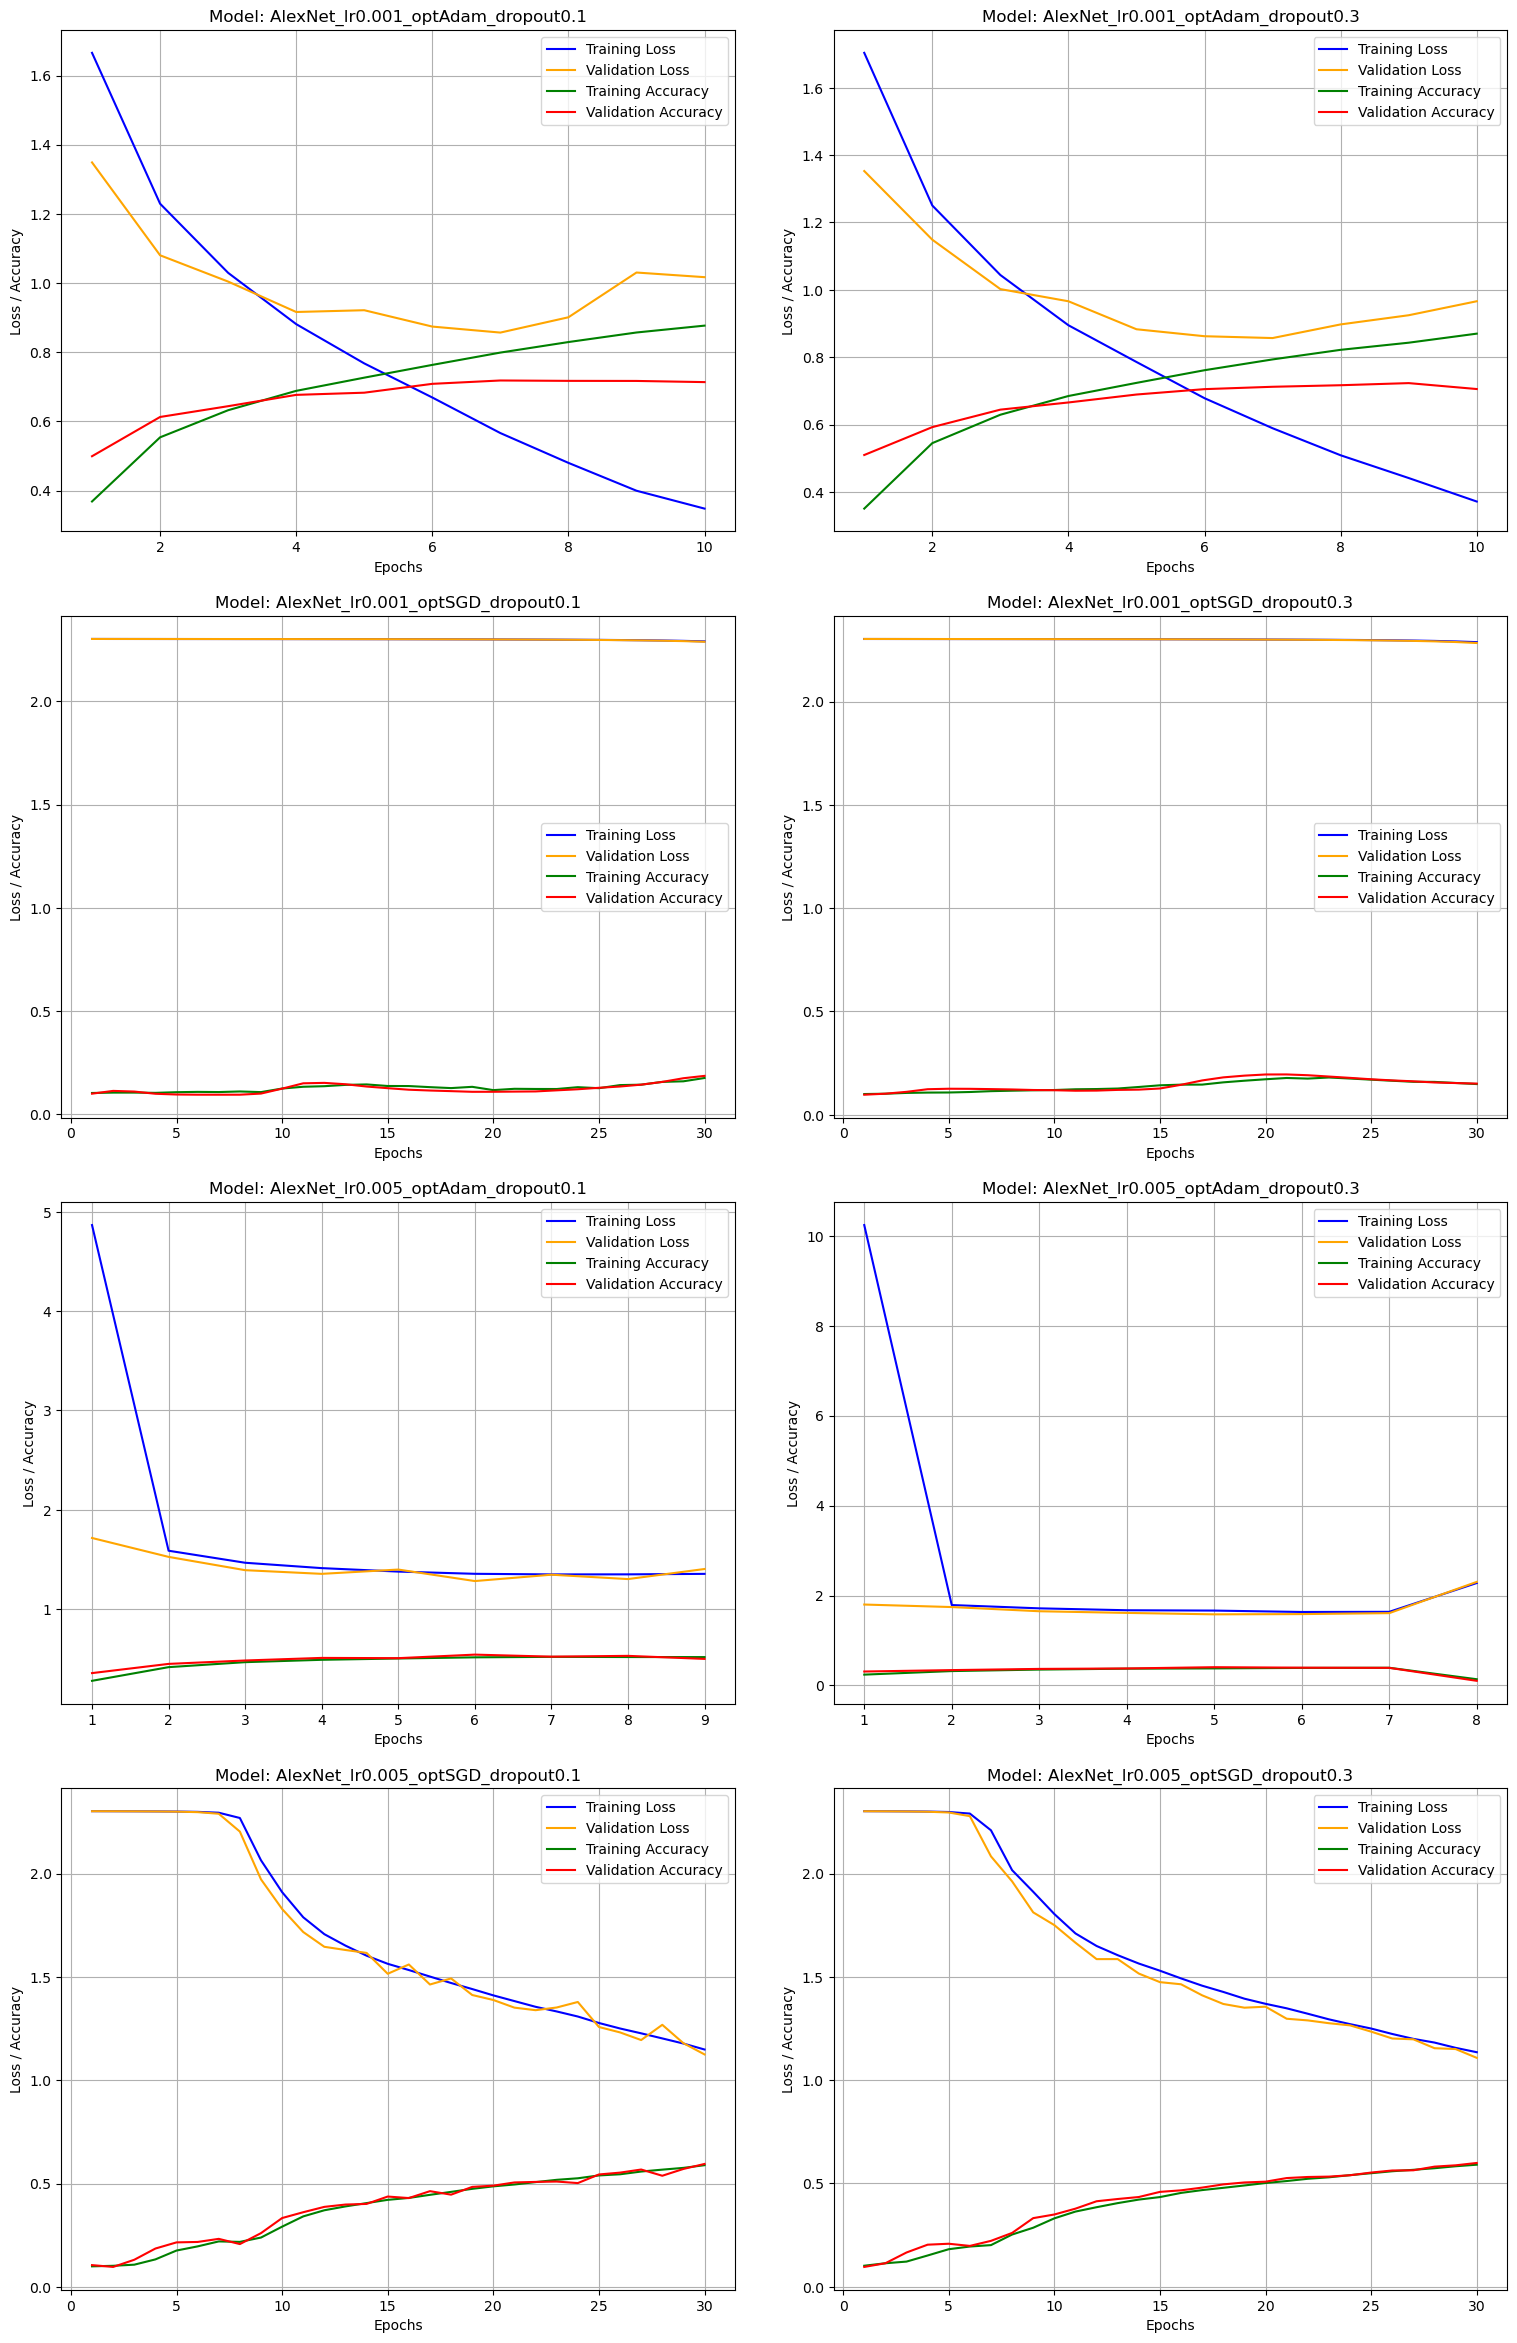

In [67]:
results = []
for lr, optimizer, dropout_rate in hyperparameter_combinations:
    optimizer_name = optimizer.__name__
    model_name = f"AlexNet_lr{lr}_opt{optimizer_name}_dropout{dropout_rate}"
    
    # Load the saved history from JSON
    history_path = f"saved_models_tor/{model_name}_history.json"
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
        
        # Append the result with a placeholder result_df and the model name
        # Here, result_df is assumed to be empty as we're focusing on history for plotting
        results.append((None, history, model_name))
perf_plot_grid(results, 4, 2, 16, 24)

In [14]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, dropout_rate=0.0, input_shape=(32, 32, 3), num_classes=10):
        super(VGG16, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(input_shape[2], 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),  # For CIFAR-10 size (32x32), this may need adjustment
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Function to create an instance of VGG16
def build_vgg16(dropout_rate=0.0, input_shape=(32, 32, 3), num_classes=10):
    return VGG16(dropout_rate=dropout_rate, input_shape=input_shape, num_classes=num_classes)


In [15]:
# Define parameters for VGG16
model_name = "VGG16_CIFAR10"
optimizer_class = optim.Adam
learning_rate = 0.01
dropout_rate = 0

# Train and evaluate the model using the PyTorch train_and_evaluate_cnn_model function
result_df, history, model_name = train_and_evaluate_cnn_model(
    build_vgg16,               # VGG16 model-building function
    model_name,                # Model name for saving/loading
    train_loader,              # PyTorch DataLoader for training set
    valid_loader,              # PyTorch DataLoader for validation set
    optimizer_class=optimizer_class,  # Optimizer class
    learning_rate=learning_rate,      # Learning rate
    dropout_rate=dropout_rate,        # Dropout rate
    num_epochs=30,                    # Number of epochs
    device=device                     # Device (CPU or GPU)
)

# Display the result DataFrame (accuracy) and plot performance
result_df


Loaded model from saved_models_tor\VGG16_CIFAR10.pth
Loaded training history from saved_models_tor\VGG16_CIFAR10_history.json
Model: VGG16_CIFAR10
Overall Accuracy: 9.98%


,Model Name,Overall Accuracy
0,VGG16_CIFAR10,0.0998


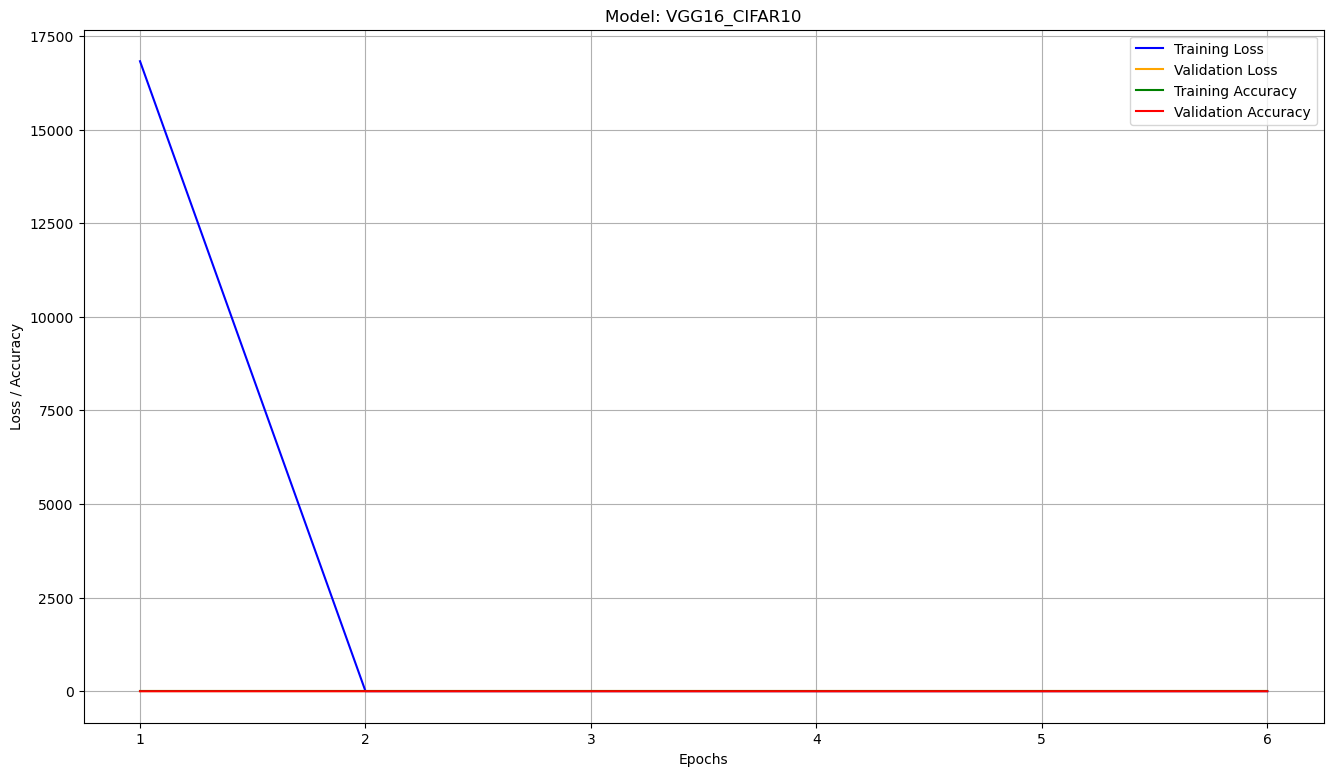

In [16]:
perf_plot(history, model_name)

In [17]:
# Define the hyperparameter grid for VGG16
learning_rates = [0.001, 0.005]
optimizers = [optim.Adam, optim.SGD]  # PyTorch optimizer classes
dropout_rates = [0.1, 0.3]

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(product(learning_rates, optimizers, dropout_rates))

results = []
for lr, optimizer_class, dropout_rate in hyperparameter_combinations:
    optimizer_name = optimizer_class.__name__
    model_name = f"VGG16_lr{lr}_opt{optimizer_name}_dropout{dropout_rate}"
    
    # Train and evaluate the model
    result_df, history, _ = train_and_evaluate_cnn_model(
        build_vgg16,             # VGG16 model-building function
        model_name,              # Model name for saving/loading
        train_loader,            # PyTorch DataLoader for training set
        valid_loader,            # PyTorch DataLoader for validation set
        optimizer_class=optimizer_class,  # Optimizer class
        learning_rate=lr,              # Learning rate
        dropout_rate=dropout_rate,     # Dropout rate
        num_epochs=30,                 # Number of epochs
        device=device                  # Device (CPU or GPU)
    )
    
    # Append the results
    results.append((result_df, history, model_name))

# Concatenate all individual result DataFrames in `results` and sort by Overall Accuracy
all_results_df = pd.concat([res[0] for res in results], ignore_index=True)
all_results_df = all_results_df.sort_values(by="Overall Accuracy", ascending=False)


Loaded model from saved_models_tor\VGG16_lr0.001_optAdam_dropout0.1.pth
Loaded training history from saved_models_tor\VGG16_lr0.001_optAdam_dropout0.1_history.json
Model: VGG16_lr0.001_optAdam_dropout0.1
Overall Accuracy: 75.11%
Epoch 1/30 - Train Loss: 2.3034, Train Acc: 0.0992, Val Loss: 2.3027, Val Acc: 0.1006
Saved model to saved_models_tor\VGG16_lr0.001_optAdam_dropout0.3.pth
Epoch 2/30 - Train Loss: 2.3028, Train Acc: 0.0964, Val Loss: 2.3028, Val Acc: 0.0973
No improvement in validation loss. Patience counter: 1/3
Epoch 3/30 - Train Loss: 2.3027, Train Acc: 0.0992, Val Loss: 2.3028, Val Acc: 0.0963
No improvement in validation loss. Patience counter: 2/3
Epoch 4/30 - Train Loss: 2.3027, Train Acc: 0.1001, Val Loss: 2.3028, Val Acc: 0.0963
No improvement in validation loss. Patience counter: 3/3
Early stopping triggered.
Training history saved to saved_models_tor\VGG16_lr0.001_optAdam_dropout0.3_history.json
Model: VGG16_lr0.001_optAdam_dropout0.3
Overall Accuracy: 10.06%
Loaded 

In [18]:
# Display the sorted results
print("All Results Sorted by Overall Accuracy:")
all_results_df

All Results Sorted by Overall Accuracy:


,Model Name,Overall Accuracy
0,VGG16_lr0.001_optAdam_dropout0.1,0.7511
3,VGG16_lr0.001_optSGD_dropout0.3,0.1025
4,VGG16_lr0.005_optAdam_dropout0.1,0.1024
2,VGG16_lr0.001_optSGD_dropout0.1,0.1010
1,VGG16_lr0.001_optAdam_dropout0.3,0.1006
6,VGG16_lr0.005_optSGD_dropout0.1,0.0973
7,VGG16_lr0.005_optSGD_dropout0.3,0.0973
5,VGG16_lr0.005_optAdam_dropout0.3,0.0967


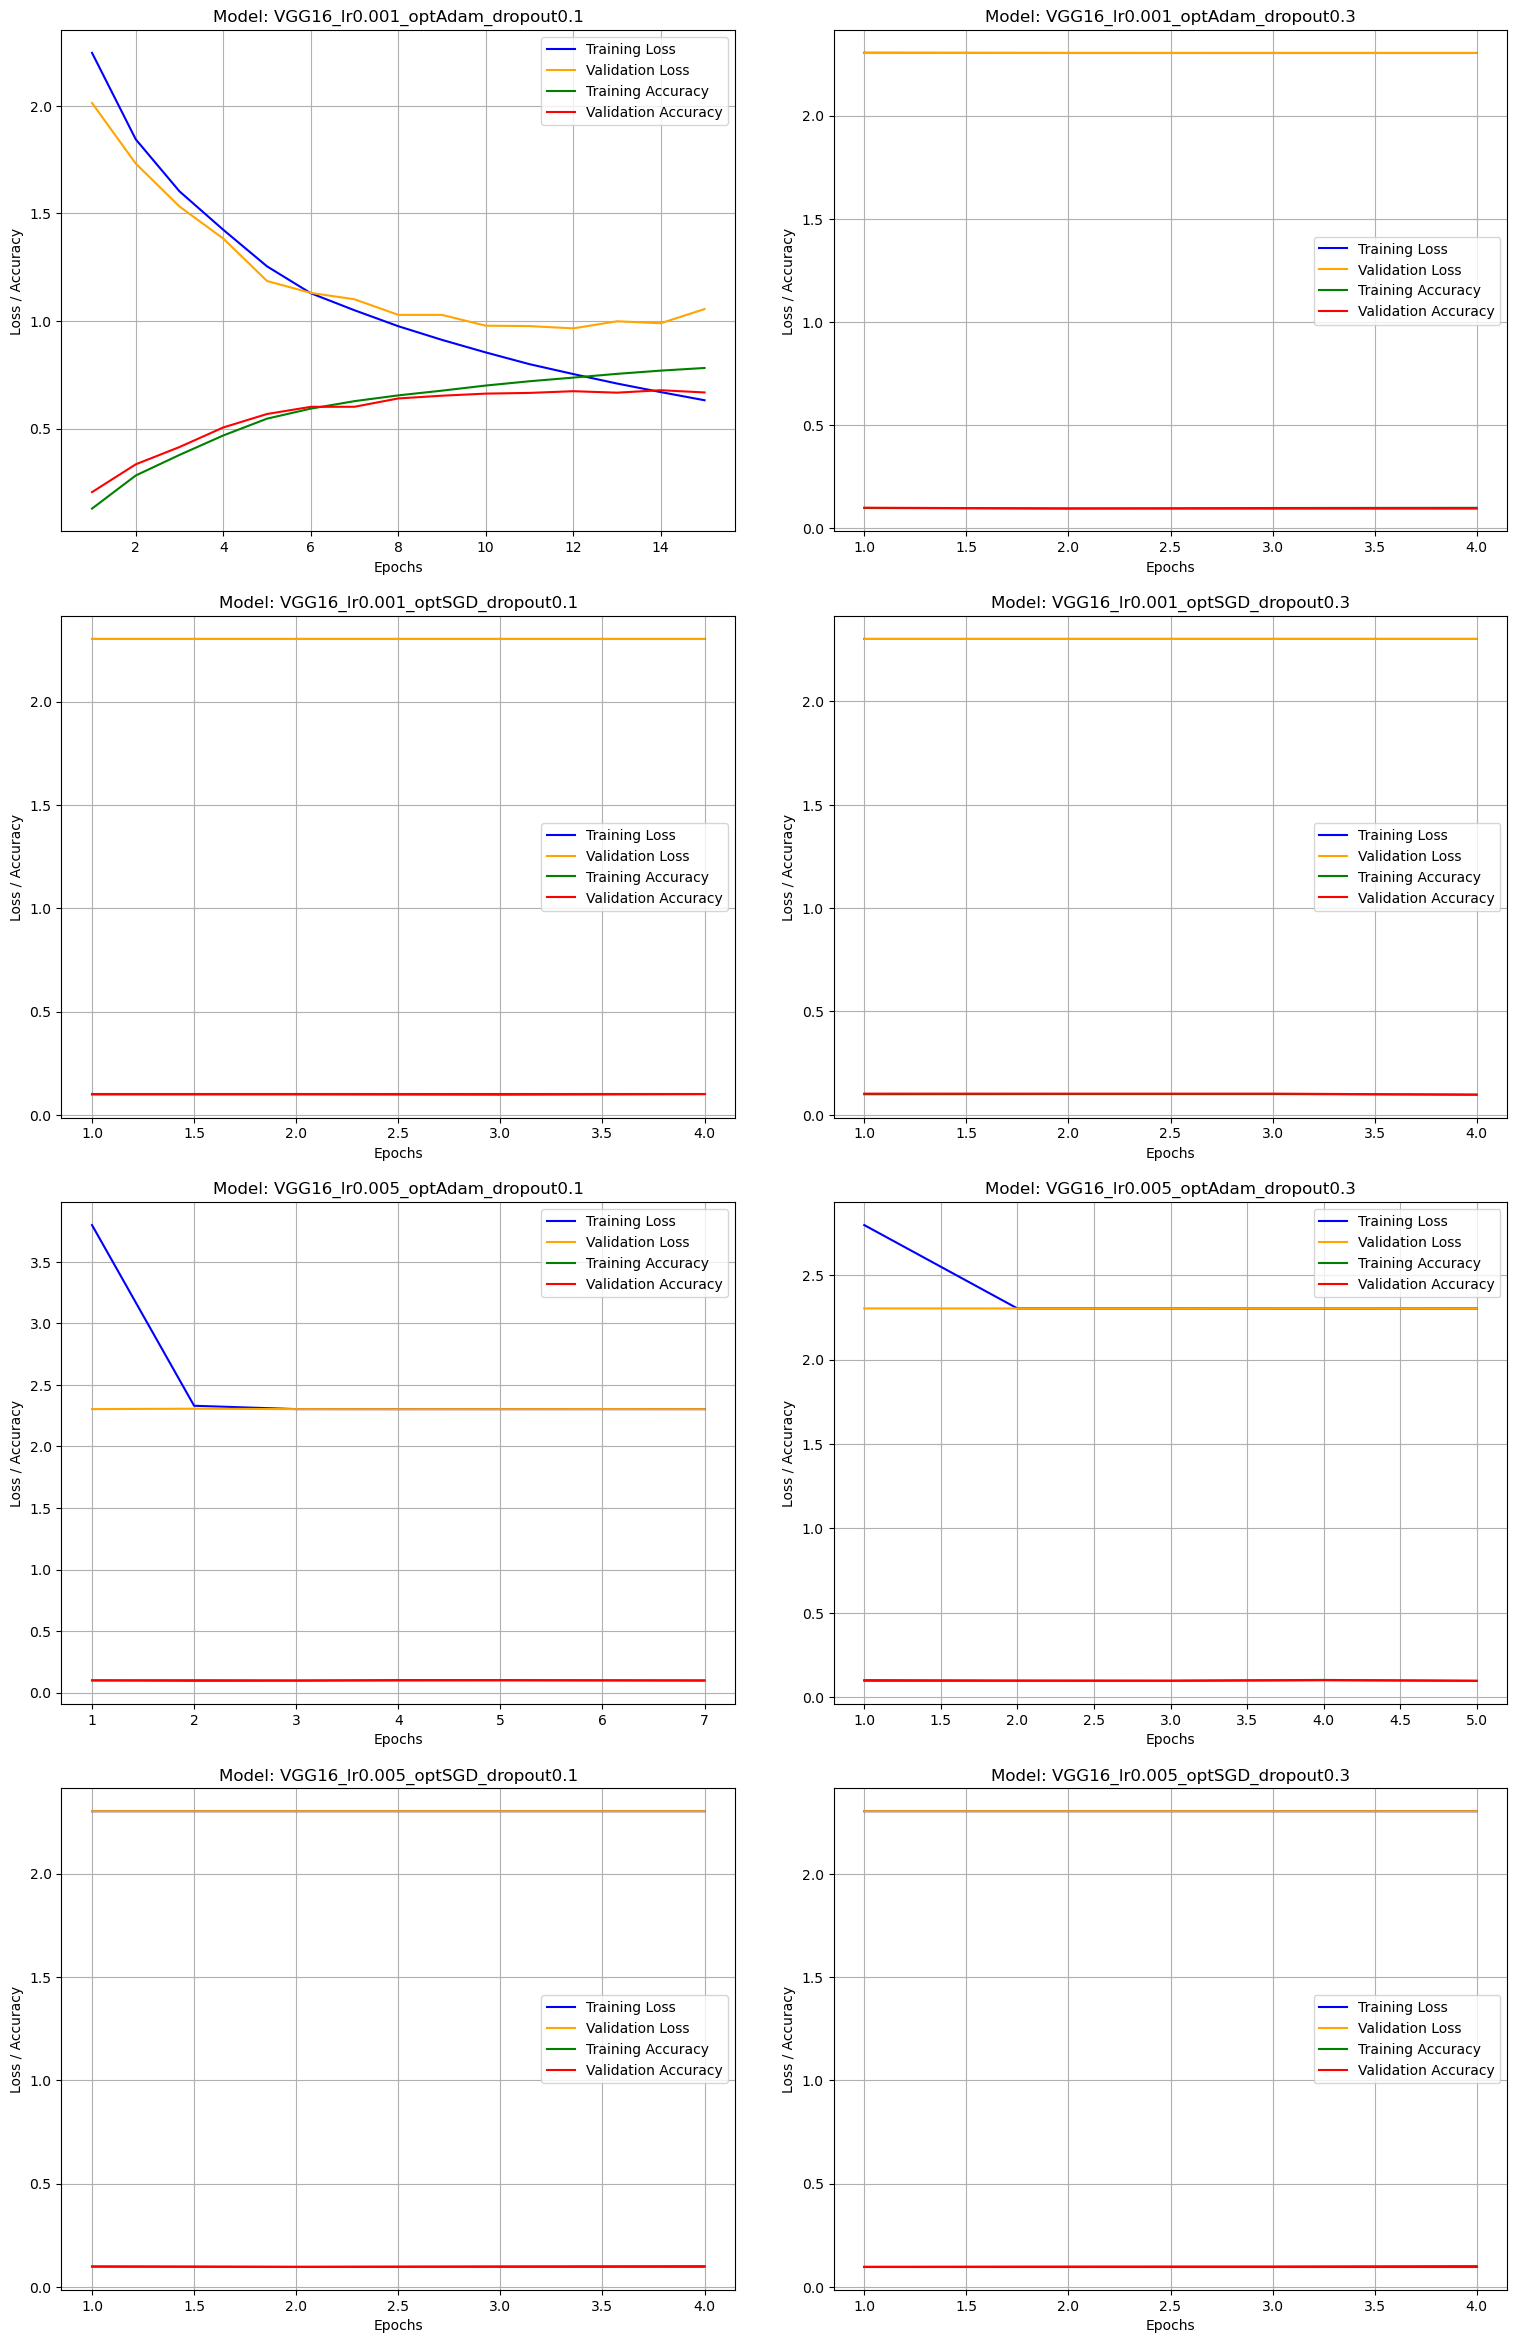

In [19]:
results = []
for lr, optimizer_class, dropout_rate in hyperparameter_combinations:
    optimizer_name = optimizer_class.__name__
    model_name = f"VGG16_lr{lr}_opt{optimizer_name}_dropout{dropout_rate}"
    
    # Load the saved history from JSON
    history_path = f"saved_models_tor/{model_name}_history.json"
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
        
        # Append the result with a placeholder result_df and the model name
        # Here, result_df is assumed to be empty as we're focusing on history for plotting
        results.append((None, history, model_name))

# Plot all performance curves in a 4x2 layout
perf_plot_grid(results, 4, 2, 16, 24)

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += shortcut
        x = self.relu(x)
        return x

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, stride):
        layers = [
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, stride=1)
        ]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Function to create an instance of ResNet18
def build_resnet18(num_classes=10):
    return ResNet18(num_classes=num_classes)


In [21]:
# Define parameters
model_name = "ResNet18_CIFAR10"
optimizer_class = optim.Adam  # Optimizer in PyTorch
learning_rate = 0.001

# Train and evaluate the model using the PyTorch train_and_evaluate_cnn_model function
result_df, history, model_name = train_and_evaluate_cnn_model(
    build_resnet18,           # Model-building function for ResNet-18
    model_name,                # Model name for saving/loading
    train_loader,              # PyTorch DataLoader for training set
    valid_loader,              # PyTorch DataLoader for validation set
    optimizer_class=optimizer_class,  # Optimizer class
    learning_rate=learning_rate,      # Learning rate
    num_epochs=30,                    # Number of epochs
    device=device                     # Device (CPU or GPU)
)
result_df

Loaded model from saved_models_tor\ResNet18_CIFAR10.pth
Loaded training history from saved_models_tor\ResNet18_CIFAR10_history.json
Model: ResNet18_CIFAR10
Overall Accuracy: 88.37%


,Model Name,Overall Accuracy
0,ResNet18_CIFAR10,0.8837


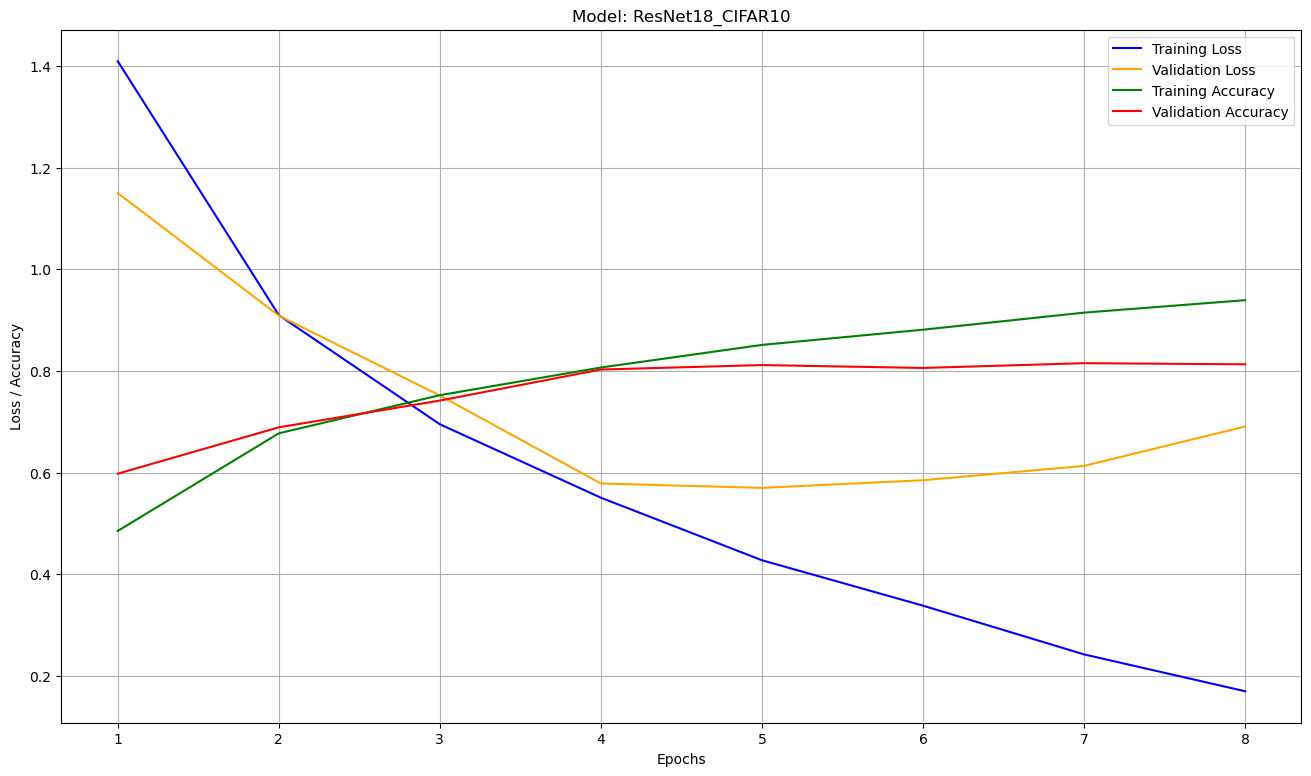

In [22]:

perf_plot(history, model_name)

In [23]:
# Define the hyperparameter grid
learning_rates = [0.001, 0.005]
optimizers = [optim.Adam, optim.SGD]  # PyTorch optimizer classes

# Create all combinations of hyperparameters
hyperparameter_combinations = list(product(learning_rates, optimizers))


In [24]:
# Store results for each hyperparameter combination
results = []

# Tune over all hyperparameter combinations
for lr, optimizer_class in hyperparameter_combinations:
    optimizer_name = optimizer_class.__name__
    model_name = f"ResNet18_lr{lr}_opt{optimizer_name}"
    
    # Train and evaluate the model
    result_df, history, _ = train_and_evaluate_cnn_model(
        build_resnet18,           # Model-building function for ResNet-18
        model_name,               # Model name for saving/loading
        train_loader,             # PyTorch DataLoader for training set
        valid_loader,             # PyTorch DataLoader for validation set
        optimizer_class=optimizer_class,  # Optimizer class
        learning_rate=lr,         # Learning rate
        num_epochs=30,            # Number of epochs
        device=device             # Device (CPU or GPU)
    )
    
    # Append the results to the list
    results.append((result_df, history, model_name))

# Concatenate all individual result DataFrames in `results` and sort by Overall Accuracy
all_results_df = pd.concat([res[0] for res in results], ignore_index=True)
all_results_df = all_results_df.sort_values(by="Overall Accuracy", ascending=False)

# Display the sorted results
print("All Results Sorted by Overall Accuracy:")
all_results_df

Loaded model from saved_models_tor\ResNet18_lr0.001_optAdam.pth
Loaded training history from saved_models_tor\ResNet18_lr0.001_optAdam_history.json
Model: ResNet18_lr0.001_optAdam
Overall Accuracy: 91.41%
Loaded model from saved_models_tor\ResNet18_lr0.001_optSGD.pth
Loaded training history from saved_models_tor\ResNet18_lr0.001_optSGD_history.json
Model: ResNet18_lr0.001_optSGD
Overall Accuracy: 77.27%
Epoch 1/30 - Train Loss: 1.6700, Train Acc: 0.3863, Val Loss: 1.3543, Val Acc: 0.5075
Saved model to saved_models_tor\ResNet18_lr0.005_optAdam.pth
Epoch 2/30 - Train Loss: 1.1376, Train Acc: 0.5920, Val Loss: 0.9807, Val Acc: 0.6490
Saved model to saved_models_tor\ResNet18_lr0.005_optAdam.pth
Epoch 3/30 - Train Loss: 0.8639, Train Acc: 0.6943, Val Loss: 0.7902, Val Acc: 0.7189
Saved model to saved_models_tor\ResNet18_lr0.005_optAdam.pth
Epoch 4/30 - Train Loss: 0.6896, Train Acc: 0.7587, Val Loss: 0.6854, Val Acc: 0.7591
Saved model to saved_models_tor\ResNet18_lr0.005_optAdam.pth
Epoch

,Model Name,Overall Accuracy
0,ResNet18_lr0.001_optAdam,0.9141
1,ResNet18_lr0.001_optSGD,0.7727
2,ResNet18_lr0.005_optAdam,0.7657
3,ResNet18_lr0.005_optSGD,0.6842


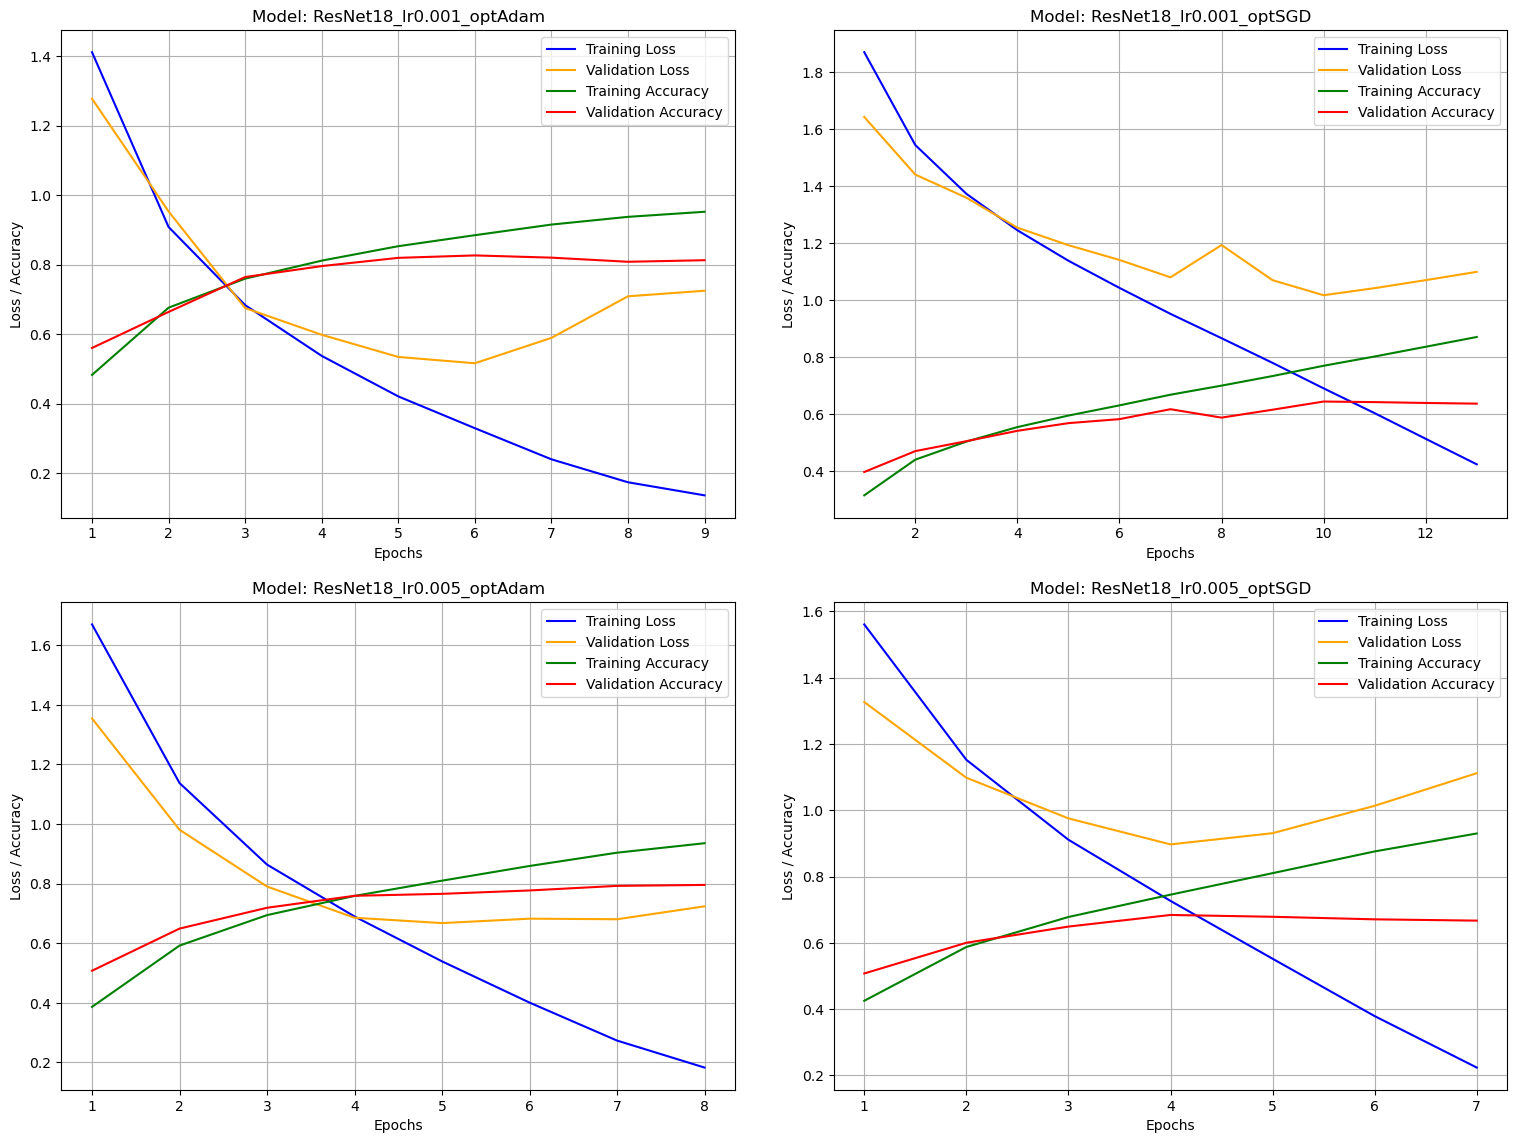

In [25]:
# Plot all performance curves in a 4x2 layout
perf_plot_grid(results, 2, 2, 16, 12)

In [27]:
# Define the model names and directory where models are saved
model_names = [
    "AlexNet_lr0.001_optAdam_dropout0.1",
    "VGG16_lr0.001_optAdam_dropout0.1",
    "ResNet18_lr0.001_optAdam"
]
model_dir = "saved_models_tor"

# Criterion for calculating test loss
criterion = nn.CrossEntropyLoss()

# Evaluate each model
for model_name in model_names:
    # Load the model structure
    if "AlexNet" in model_name:
        model = build_alexnet(dropout_rate=0.5)
    elif "VGG16" in model_name:
        model = build_vgg16(dropout_rate=0.5)
    elif "ResNet18" in model_name:
        model = build_resnet18()
    else:
        raise ValueError("Unknown model type in model_names list.")
    
    # Load model weights
    model_path = f"{model_dir}/{model_name}.pth"
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    # Initialize metrics
    test_loss = 0.0
    correct = 0
    total = 0

    # Evaluate on the test set
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Calculate average loss and accuracy
    test_loss /= total
    test_accuracy = correct / total

    # Print the results
    print(f"Model: {model_name}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("-" * 30)


Model: AlexNet_lr0.001_optAdam_dropout0.1
Test Loss: 0.8767
Test Accuracy: 0.7116
------------------------------
Model: VGG16_lr0.001_optAdam_dropout0.1
Test Loss: 0.9538
Test Accuracy: 0.6844
------------------------------
Model: ResNet18_lr0.001_optAdam
Test Loss: 0.5415
Test Accuracy: 0.8231
------------------------------
